In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'viridis'

from PIL import Image
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
marker_list = ['o', 's', 'x', '^']
from inference import *

In [2]:
import os
import pandas as pd
import io  # Import the io module

# Directory containing the data files
data_dir = "./data/SNSNSE/PEO"

# Initialize a list to store the data
snsnse_data = []
q_list = [0.054617, 0.060893, 0.068026, 0.076566, 0.085363, 0.095363, 0.109311, 0.121871, 0.136147, 0.153085, 0.170674, 0.190667]

# Load data from data.csv
data_csv_path = os.path.join(data_dir, "data.csv")
data_csv = pd.read_csv(data_csv_path, header=None)

# Iterate through q_list to extract data for each Q
for i, q in enumerate(q_list):
    # Extract columns for the current Q
    t_col = i * 3
    I_col = i * 3 + 1
    I_err_col = i * 3 + 2

    # Create a DataFrame for the current Q, excluding rows with NaN values
    data = pd.DataFrame({
        "t": data_csv.iloc[:, t_col],
        "I": data_csv.iloc[:, I_col],
        "I_err": data_csv.iloc[:, I_err_col],
    }).dropna()  # Drop rows with NaN values
    data["Q"] = q  # Add Q value as a column
    data["Filename"] = f"q{i+1}.csv"  # Add filename as a column

    # Append the DataFrame to the list
    snsnse_data.append(data)

# Combine all data into a single DataFrame
snsnse_df_all = pd.concat(snsnse_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(snsnse_df_all.head())


          t         I     I_err         Q Filename
0  0.116531  0.985567  0.006040  0.054617   q1.csv
1  0.155138  0.978829  0.005967  0.054617   q1.csv
2  0.310114  0.997554  0.006267  0.054617   q1.csv
3  0.619726  0.989342  0.006382  0.054617   q1.csv
4  1.161482  0.983702  0.006116  0.054617   q1.csv


In [3]:
snsnse_df_all

,t,I,I_err,Q,Filename
0,0.116531,0.985567,0.006040,0.054617,q1.csv
1,0.155138,0.978829,0.005967,0.054617,q1.csv
2,0.310114,0.997554,0.006267,0.054617,q1.csv
3,0.619726,0.989342,0.006382,0.054617,q1.csv
4,1.161482,0.983702,0.006116,0.054617,q1.csv
...,...,...,...,...,...
154,2.403830,0.346019,0.017730,0.190667,q12.csv
155,4.807262,0.272024,0.017451,0.190667,q12.csv
156,9.613659,0.196414,0.017805,0.190667,q12.csv
157,19.226477,0.137115,0.022889,0.190667,q12.csv


## 20C

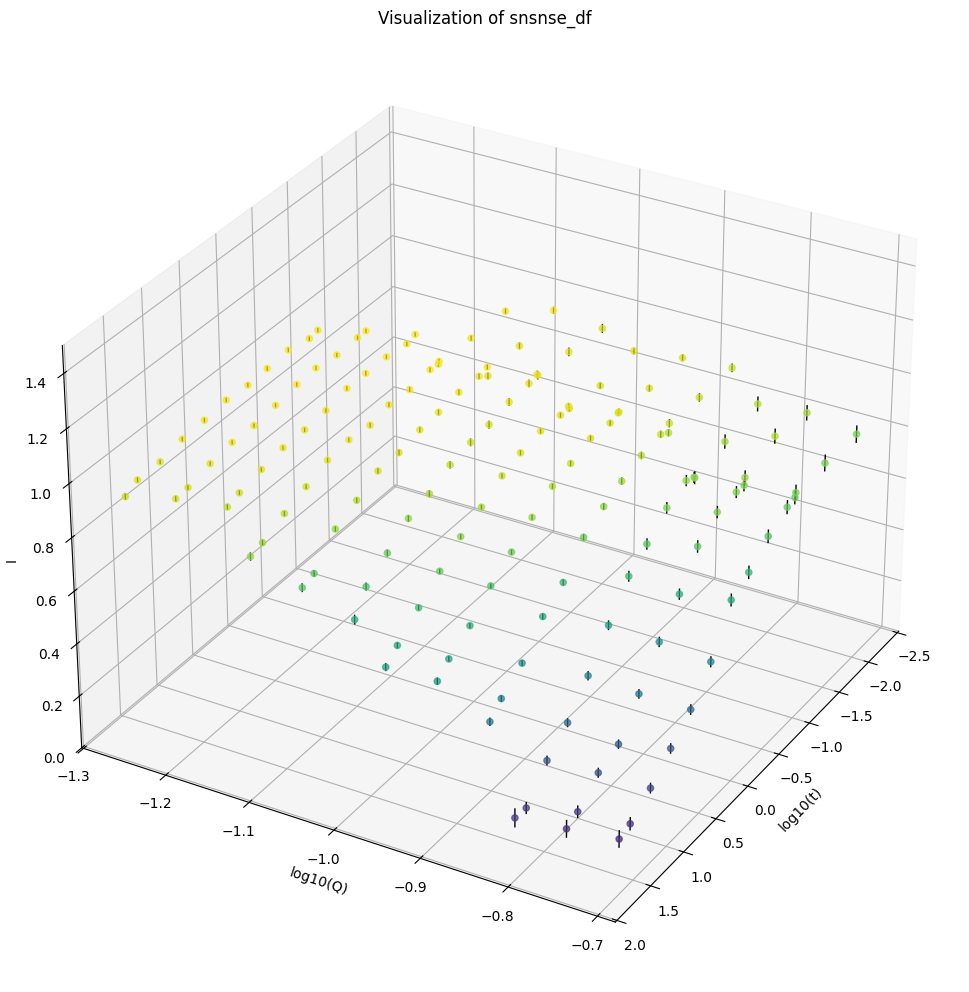

In [4]:
snsnse_df = snsnse_df_all
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract data from snsnse_df
x = np.log10(snsnse_df['t'])
y = np.log10(snsnse_df['Q'])
z = snsnse_df['I']
zerr = snsnse_df['I_err']

# Scatter plot with error bars
sc = ax.scatter(x, y, z, c=z, cmap=cmap, alpha=0.7, vmax=1, vmin=0, marker='o')

# Add vertical error bars
for xi, yi, zi, ezi in zip(x, y, z, zerr):
    ax.plot([xi, xi], [yi, yi], [zi - ezi, zi + ezi], color='k', alpha=1, linewidth=1)

# Set plot properties
ax.view_init(elev=30, azim=30)
ax.set_zlim(0, 1.5)
ax.set_xlabel('log10(t)')
ax.set_ylabel('log10(Q)')
ax.set_zlabel('I', rotation=90)
ax.set_title('Visualization of snsnse_df')

plt.tight_layout(pad=1.0)

# Prepare concatenated lists
Q_flattened_list = [snsnse_df['Q'].values]
t_flattened_list = [snsnse_df['t'].values]
echo_flattened_list = [snsnse_df['I'].values]
echo_err_flattened_list = [snsnse_df['I_err'].values]
average_list = [snsnse_df['I'].values]
average_err_list = [snsnse_df['I_err'].values]

sqt_list = [np.concatenate(echo_flattened_list)]
sqt_err_list = [np.concatenate(echo_err_flattened_list)]
Q_flattened = np.concatenate(Q_flattened_list)
t_flattened = np.concatenate(t_flattened_list)
I_0_list = [np.concatenate(average_list, axis=0)]
I_0_err_list = [np.concatenate(average_err_list, axis=0)]


In [5]:
np.unique(Q_flattened_list)

array([0.054617, 0.060893, 0.068026, 0.076566, 0.085363, 0.095363,
       0.109311, 0.121871, 0.136147, 0.153085, 0.170674, 0.190667])

L: 239, M: 759, N: 15


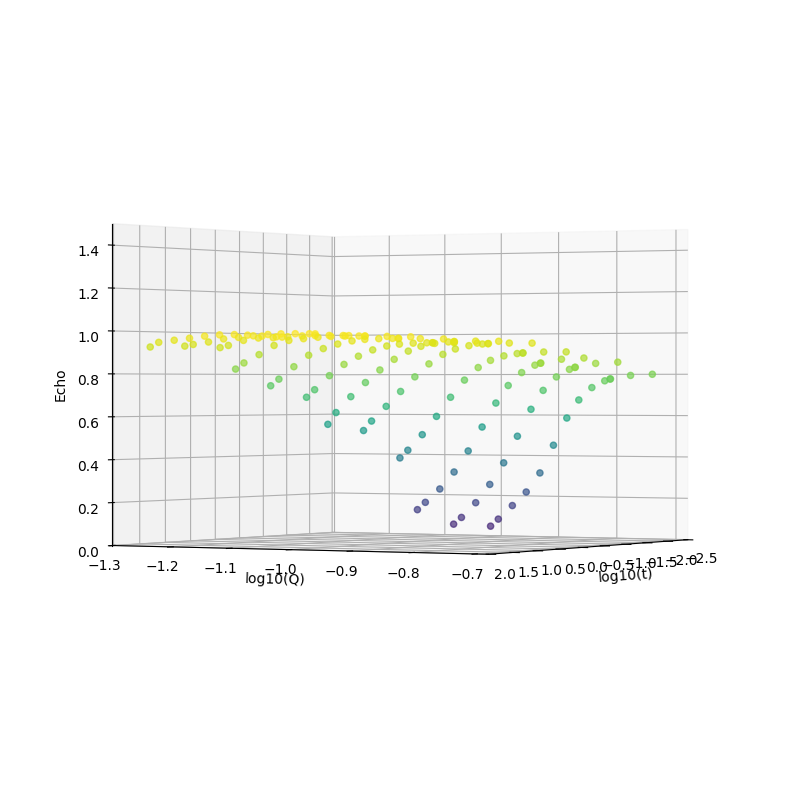

In [6]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
sqt_GPR_list = []
sqt_GPR_err_list = []
A_GPR_list = []

ax = fig.add_subplot(111, projection='3d')

sqt_exp = sqt_list[0]  # Assuming the first element of sqt_list is used
delta_sqt_exp = sqt_err_list[0]
Q_obs = Q_flattened
t_obs = t_flattened

# Append the observed data with known BCs
Q_unique = np.unique(Q_obs)
Q_app_grid, t_app_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min()), np.log10(Q_obs.max()), 30), np.logspace(1, 2, 20))
t_zero = np.exp(-np.logspace(0, np.log10(Q_obs.max()) - np.log10(Q_obs.min()), 30)) * 2e3
t_app_grid = t_app_grid * t_zero
Q_app = Q_app_grid.flatten()
t_app = t_app_grid.flatten()
sqt_exp_app = np.zeros_like(Q_app)
epsilon_app = 1e-3
delta_sqt_exp_app = np.ones_like(t_app) * epsilon_app
Q_obs_app = np.concatenate([Q_obs, Q_app])
t_obs_app = np.concatenate([t_obs, t_app])
sqt_exp_app = np.concatenate([sqt_exp, sqt_exp_app])
delta_sqt_exp_app = np.concatenate([delta_sqt_exp, delta_sqt_exp_app])

Q_eval_grid, t_eval_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min())*0.9, np.log10(Q_obs.max())*1.1, 40), np.logspace(-1.5, 2.5, 2))
Q_eval = Q_eval_grid.flatten()
t_eval = t_eval_grid.flatten()
Q_eval = np.concatenate([Q_obs, Q_eval])
t_eval = np.concatenate([t_obs, t_eval])

lambda_ = 0.2
mu_ = lambda_

N_Prony = 15
# Using a nonlinear spacing (quadratic in log-space)
log_tau_dense = 0 + (3 - 0) * (np.linspace(0, 1, N_Prony) ** 2)
list_tau_i = 10 ** log_tau_dense
tau = np.array(list_tau_i)
bg_mode = False

A_GPR, K_GPR, sqt_GPR = bayesian_inference(
    sqt_exp_app, delta_sqt_exp_app, np.log(Q_obs_app), t_obs_app, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode, sigma_scale=0.1, prior_mean_scale=0.0, use_diffusivity_prior=False
)

sqt_GPR_obs = sqt_GPR[:len(sqt_exp)]
sqt_GPR_list.append(sqt_GPR_obs)
A_GPR_list.append(A_GPR)

ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR_obs, c=sqt_GPR_obs, alpha=0.7, vmax=1, vmin=0)

ax.view_init(elev=0, azim=30)
ax.set_zlim(0, 1.5)
ax.set_xlabel('log10(t)')
ax.set_ylabel('log10(Q)')
ax.set_zlabel('Echo', rotation=90)
ax.set_box_aspect(None, zoom=0.85)


In [7]:
Q_unique

array([0.054617, 0.060893, 0.068026, 0.076566, 0.085363, 0.095363,
       0.109311, 0.121871, 0.136147, 0.153085, 0.170674, 0.190667])

In [8]:
# from scipy.optimize import curve_fit
# fig = plt.figure(figsize=(10, 10))
# for i, duration in enumerate(duration_list):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     axs.append(ax)
    
#     sqt_GPR = sqt_GPR_list[i]
#     sqt_exp = sqt_list[i]
#     sqt_exp_err = sqt_err_list[i]
#     # sqt_exp_err_lt 

    
#     ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR-sqt_exp_lt, c=sqt_GPR-sqt_exp_lt, alpha=1, vmax=0.5, vmin=-0.5, cmap="bwr")
#     # ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp-sqt_exp_lt, c='k', alpha=0.7, vmax=0.5, vmin=-0.5, cmap="bwr")
    
#     print(np.sqrt(np.mean(((sqt_GPR-sqt_exp_lt))**2)))

#     ax.view_init(elev=30, azim=30)
#     ax.set_zlim(-1, 1)
#     ax.set_xlabel('log10(t)')
#     ax.set_ylabel('log10(Q)')
#     ax.set_zlabel('Echo', rotation=90)
#     ax.set_box_aspect(None, zoom=0.85)
#     ax.set_title(f'Duration: {duration} s')
    
# plt.tight_layout(pad=1.0)

Q=0.0546, S0=0.9906, tau=3387.6370, beta=0.6667, bg=0.0000
Q=0.0609, S0=0.9964, tau=639.0822, beta=0.6666, bg=0.5000
Q=0.0680, S0=0.9931, tau=362.6575, beta=0.6666, bg=0.5000
Q=0.0766, S0=0.9871, tau=235.1495, beta=0.6666, bg=0.5000
Q=0.0854, S0=0.9810, tau=120.9870, beta=0.6667, bg=0.3146
Q=0.0954, S0=0.9588, tau=56.2340, beta=0.6666, bg=0.2877
Q=0.1093, S0=0.9664, tau=23.4996, beta=0.6666, bg=0.5000
Q=0.1219, S0=0.9594, tau=11.1487, beta=0.6666, bg=0.5000
Q=0.1361, S0=0.9310, tau=5.9771, beta=0.6666, bg=0.3824
Q=0.1531, S0=0.8825, tau=5.9884, beta=0.6666, bg=0.1573
Q=0.1707, S0=0.8897, tau=3.1320, beta=0.6666, bg=0.1533
Q=0.1907, S0=0.8166, tau=2.4405, beta=0.6666, bg=0.1227


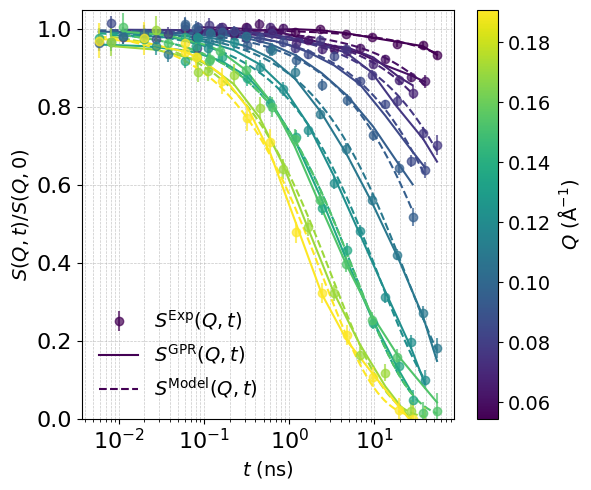

In [79]:
from scipy.optimize import curve_fit
import matplotlib.cm as cm  # Import cm from matplotlib
import matplotlib.pyplot as plt  # Ensure plt is imported

cmap = plt.get_cmap('viridis')  # Use plt.get_cmap instead of cm.get_cmap

# Define the stretched exponential function with a background constant
def f_sexp(t, s0, tau, beta, bg):
    return (s0-bg) * np.exp(-(t / tau) ** beta) + bg

def f_sexp_log(t, s0, tau, beta, bg):
    return np.log((s0-bg) * np.exp(-(t / tau) ** beta) + bg)

from scipy.special import gamma

def relaxation_time(tau, beta):
    """
    Compute the integral of exp(-(t/tau)**beta) from t=0 to infinity.
    
    Parameters
    ----------
    tau : float or array-like
        Characteristic time constant (τ > 0).
    beta : float or array-like
        Stretching exponent (β > 0).

    Returns
    -------
    float or ndarray
        The relaxation time: (tau / beta) * Gamma(1 / beta).
    """
    return (tau / beta) * gamma(1.0 / beta)
    
# Create a figure for the plots
fig, ax = plt.subplots(figsize=(6, 5))

# Loop through each unique Q value
unique_Q = np.unique(snsnse_df['Q'])
norm = matplotlib.colors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
Gamma_list = []
Gamma_integral_list = []
for i_q, q in enumerate(unique_Q):
    # Filter the data for the current Q value
    mask = snsnse_df['Q'] == q
    t_filtered = snsnse_df.loc[mask, 't']
    I_filtered = snsnse_df.loc[mask, 'I']
    I_err_filtered = snsnse_df.loc[mask, 'I_err']

    # Fit the data to the stretched exponential function with background
    try:
        popt, _ = curve_fit(
            f_sexp_log, 
            t_filtered, 
            np.log(I_filtered), 
            p0=[np.max(I_filtered), 0.1, 2/3, 0], 
            bounds=([np.max(I_filtered)/2, 0, 1.9999/3, 0], [np.max(I_filtered)*1.02, np.inf, 2.0001/3, 0.5]), 
            maxfev=100000
        )
        s0_fit, tau_fit, beta_fit, bg_fit = popt
        print(f"Q={q:.4f}, S0={s0_fit:.4f}, tau={tau_fit:.4f}, beta={beta_fit:.4f}, bg={bg_fit:.4f}")

        # Generate fitted curve
        t_fine = np.logspace(np.log10(t_filtered.min()), np.log10(t_filtered.max()), 100)
        I_fitted = f_sexp(t_fine, s0_fit, tau_fit, beta_fit, bg_fit)
        Gamma_list.append(1/tau_fit)
        Gamma_integral = 1/relaxation_time(tau_fit, beta_fit)
        Gamma_integral_list.append(Gamma_integral)

        # Plot the data with error bars
        color = cmap(norm(q))
        label = ''
        if i_q == 0:
            label = '$S^{\mathrm{Exp}}(Q,t)$' 
        ax.errorbar(t_filtered, (I_filtered-bg_fit)/(s0_fit-bg_fit), yerr=I_err_filtered/(s0_fit-bg_fit), fmt='o', label=label, alpha=0.7, color=color)
        label = ''
        if i_q == 0:
            label = '$S^{\mathrm{Model}}(Q,t)$' 
        ax.plot(t_fine, (I_fitted-bg_fit)/(s0_fit-bg_fit), '--', color=color, label=label)
    except RuntimeError:
        print(f"Fit failed for Q={q:.2f}")

    # Overlay GPR predictions
    mask_gpr = Q_obs == q
    t_gpr = t_obs[mask_gpr]
    sqt_gpr = sqt_GPR_list[0][mask_gpr]  # Assuming the first element of sqt_GPR_list is used
    sqt_gpr[sqt_gpr < 0] = 1e-6  # Set GPR results less than 0 to 1e-6
    sqt_gpr_plot = sqt_gpr.copy()
    # for i_s, s in enumerate(sqt_gpr_plot):
    #     if i_s > 0 and s >= sqt_gpr_plot[i_s - 1]:
    #         sqt_gpr_plot[i_s] = sqt_gpr_plot[i_s - 1] * 0.1
    label = ''
    if i_q == 0:
        label = '$S^{\mathrm{GPR}}(Q,t)$' 
    ax.plot(t_gpr, (sqt_gpr_plot-bg_fit)/(s0_fit-bg_fit), '-', color=color, label=label)

# Set axis scales and labels
ax.set_xscale('log')
ax.set_xlabel(r'$t$ (ns)', fontsize=14)
ax.set_ylabel(r'$S(Q, t)/S(Q, 0)$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.set_title('I(Q, t) vs t with Stretched Exponential Fits and GPR Predictions', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax.set_xlim(0.1, 100)
ax.set_ylim(0, 1.05)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14, loc='lower left', frameon=False)
# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

Slope: 5.568902470421793, Intercept: 8.881557230492499
Slope: 5.568857390789509, Intercept: 8.596736308087527


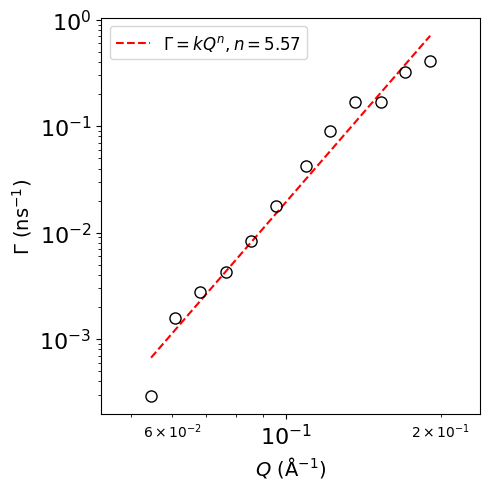

In [78]:
from scipy.optimize import curve_fit

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Define a linear function for fitting in log-log space
def linear_func(log_q, slope, intercept):
    return slope * log_q + intercept

# Perform the fit
log_q = np.log(q_list)
log_Gamma = np.log(Gamma_list)
popt, _ = curve_fit(linear_func, log_q, log_Gamma)

# Extract the slope and intercept
slope, intercept = popt
print(f"Slope: {slope}, Intercept: {intercept}")

log_Gamma_integral = np.log(Gamma_integral_list)
popt, _ = curve_fit(linear_func, log_q, log_Gamma_integral)

# Extract the slope and intercept
slope_integral, intercept_integral = popt
print(f"Slope: {slope_integral}, Intercept: {intercept_integral}")

# Plot the fitted line
q_fine = np.logspace(np.log10(q_list[0]), np.log10(q_list[-1]), 100)
Gamma_fitted = np.exp(linear_func(np.log(q_fine), slope, intercept))
Gamma_integral_fitted = np.exp(linear_func(np.log(q_fine), slope_integral, intercept_integral))

ax.plot(q_fine, Gamma_fitted, 'r--', label=f'$\Gamma=kQ^n, n={slope:.2f}$')
# ax.plot(q_fine, Gamma_integral_fitted, 'b--', label=rf'$\Gamma_=kQ^n, n={slope_integral:.2f}$')
ax.legend(fontsize=12)

ax.plot(q_list, Gamma_list, 'ko', fillstyle='none', markersize=8)
# ax.plot(q_list, Gamma_integral_list, 'ks', fillstyle='none', markersize=8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((q_list[0]/1.25, q_list[-1]*1.25))
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=14)
ax.set_ylabel(r'$\Gamma$ (ns$^{-1}$)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

Q=0.05, S0=0.9900, tau=2408.5430, beta=0.7246
Q=0.06, S0=1.0000, tau=5425.7301, beta=0.5240
Q=0.07, S0=0.9966, tau=2411.6384, beta=0.5474
Q=0.08, S0=0.9900, tau=1092.0617, beta=0.5904
Q=0.09, S0=0.9900, tau=301.8577, beta=0.5849
Q=0.10, S0=0.9900, tau=181.0732, beta=0.4727
Q=0.11, S0=0.9900, tau=216.7068, beta=0.4452
Q=0.12, S0=0.9935, tau=131.7014, beta=0.4002
Q=0.14, S0=0.9900, tau=36.4072, beta=0.3838
Q=0.15, S0=1.0000, tau=9.5581, beta=0.3725
Q=0.17, S0=1.0000, tau=5.2997, beta=0.3570
Q=0.19, S0=1.0000, tau=2.6540, beta=0.3386


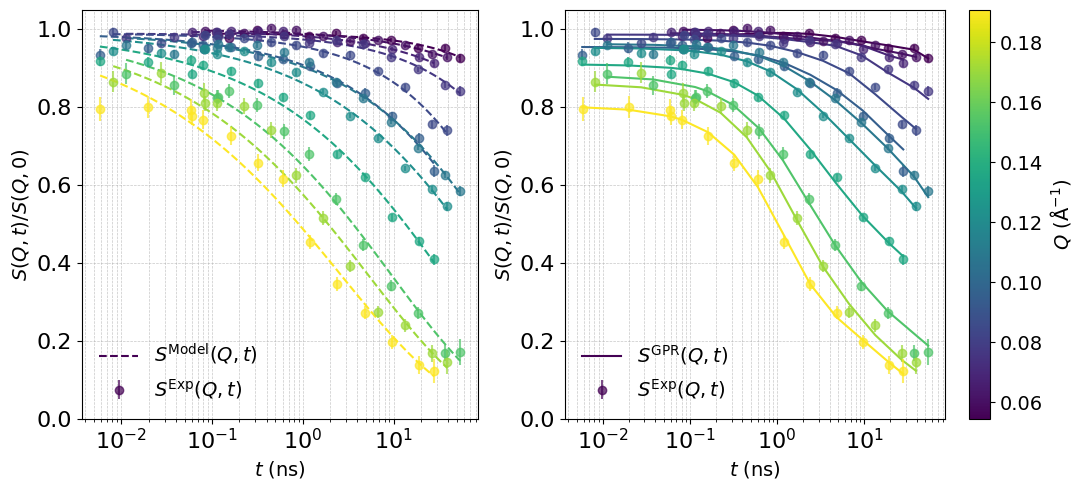

In [10]:
from scipy.optimize import curve_fit
import matplotlib.cm as cm  # Import cm from matplotlib
import matplotlib.pyplot as plt  # Ensure plt is imported

cmap = plt.get_cmap('viridis')  # Use plt.get_cmap instead of cm.get_cmap

# Define the stretched exponential function
def f_sexp(t, s0, tau, beta):
    return s0 * np.exp(-(t / tau) ** beta)

def f_sexp_log(t, s0, tau, beta):
    return np.log(s0 * np.exp(-(t / tau) ** beta))

# Create a figure for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Loop through each unique Q value
unique_Q = np.unique(snsnse_df['Q'])
norm = matplotlib.colors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
for i_q, q in enumerate(unique_Q):
    # Filter the data for the current Q value
    mask = snsnse_df['Q'] == q
    t_filtered = snsnse_df.loc[mask, 't']
    I_filtered = snsnse_df.loc[mask, 'I']
    I_err_filtered = snsnse_df.loc[mask, 'I_err']

    # Fit the data to the stretched exponential function
    try:
        popt, _ = curve_fit(f_sexp_log, t_filtered, np.log((I_filtered)), p0=[1, 1, 0.4], bounds=([0.99, 0, 0], [1, np.inf, 1]), maxfev=100000)
        s0_fit, tau_fit, beta_fit = popt
        print(f"Q={q:.2f}, S0={s0_fit:.4f}, tau={tau_fit:.4f}, beta={beta_fit:.4f}")

        # Generate fitted curve
        t_fine = np.logspace(np.log10(t_filtered.min()), np.log10(t_filtered.max()), 100)
        I_fitted = f_sexp(t_fine, s0_fit, tau_fit, beta_fit)

        # Plot the data with error bars
        color = cmap(norm(q))
        label = ''
        if i_q == 0:
            label = '$S^{\mathrm{Exp}}(Q,t)$' 
        ax1.errorbar(t_filtered, I_filtered, yerr=I_err_filtered, fmt='o', label=label, alpha=0.7, color=color)
        ax2.errorbar(t_filtered, I_filtered, yerr=I_err_filtered, fmt='o', label=label, alpha=0.7, color=color)
        label = ''
        if i_q == 0:
            label = '$S^{\mathrm{Model}}(Q,t)$' 
        ax1.plot(t_fine, I_fitted, '--', color=color, label=label)
    except RuntimeError:
        print(f"Fit failed for Q={q:.2f}")

    # Overlay GPR predictions
    mask_gpr = Q_obs == q
    t_gpr = t_obs[mask_gpr]
    sqt_gpr = sqt_GPR_list[0][mask_gpr]  # Assuming the first element of sqt_GPR_list is used
    sqt_gpr[sqt_gpr < 0] = 1e-6  # Set GPR results less than 0 to 1e-6
    sqt_gpr_plot = sqt_gpr.copy()
    # for i_s, s in enumerate(sqt_gpr_plot):
    #     if i_s > 0 and s >= sqt_gpr_plot[i_s - 1]:
    #         sqt_gpr_plot[i_s] = sqt_gpr_plot[i_s - 1] * 0.1
    label = ''
    if i_q == 0:
        label = '$S^{\mathrm{GPR}}(Q,t)$' 
    ax2.plot(t_gpr, sqt_gpr_plot, '-', color=color, label=label)

# Set axis scales and labels
ax1.set_xscale('log')
ax1.set_xlabel(r'$t$ (ns)', fontsize=14)
ax1.set_ylabel(r'$S(Q, t)/S(Q, 0)$', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=16)
# ax1.set_title('I(Q, t) vs t with Stretched Exponential Fits and GPR Predictions', fontsize=16)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax1.set_xlim(0.1, 100)
ax1.set_ylim(0, 1.05)

# Set axis scales and labels
ax2.set_xscale('log')
ax2.set_xlabel(r'$t$ (ns)', fontsize=14)
ax2.set_ylabel(r'$S(Q, t)/S(Q, 0)$', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.set_title('I(Q, t) vs t with Stretched Exponential Fits and GPR Predictions', fontsize=16)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax2.set_xlim(0.1, 100)
ax2.set_ylim(0, 1.05)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
ax1.legend(fontsize=14, loc='lower left', frameon=False)
ax2.legend(fontsize=14, loc='lower left', frameon=False)
# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()